<a href="https://colab.research.google.com/github/YulieRu/Denoising-Autoencoder/blob/main/DAE_with_PDE_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io as io
import numpy as np
import zipfile, io, os, sys
import pandas as pd

import requests, sys
import urllib.parse
from urllib.parse import urlencode

from google.colab import drive
#drive.mount('/content/drive')

import torch
from torch import nn
from torch.nn import init

from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from skimage import data,img_as_float
from skimage.util import random_noise

import random
import torch.optim as optim
from torch.utils.data import DataLoader
#from data_set import CylinderDataset
#from model import *
from matplotlib import pyplot as plt

from scipy.interpolate import griddata
import glob
from tqdm import tqdm

In [ ]:

!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
#data.to(device=device, dtype=torch.float)

device(type='cuda')

In [ ]:
import wandb

wandb.login()
#wandb.login(relogin=True)
#0799bbe19111a7329a6383d0cea56de6490475b4

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 26


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import files as filescolab

In [ ]:
#Извлекаем директории из архива
def getZipDirs(zip_f, isRootDirOnly = False, addPath = True):
  dirs = []
  for f in zip_f.namelist():
    zinfo = zip_f.getinfo(f)
    if zinfo.is_dir():
      if isRootDirOnly:     # Only root directories:
        # This is will work in any OS because the zip format specifies a forward slash.
        r_dir = f.split('/')
        r_dir = r_dir[0]
        if r_dir not in dirs:
          dirs.append(r_dir)
      else: # All directories:
          dirs.append(f)
  if addPath:
    for dir in dirs:
      sys.path.append(os.path.abspath('/content/' + dir + "/"))
  return dirs

In [ ]:

#url - путь к файлу или папке
#isZip - если передан путь к папке, то её содержимое вернется в Zip архиве

def loadTextFromYandexDisk(url: str, isZip = False):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=url))
  response = requests.get(final_url)
  download_url = response.json()['href']
  download_response = requests.get(download_url)

  if isZip:
    zip = zipfile.ZipFile(io.BytesIO(download_response.content))
    dirs = getZipDirs(zip, True)
    zip.extractall("/content/")
  else:
    download_response.encoding = download_response.apparent_encoding
    return download_response.text

In [ ]:
def eta_mol(T): #K-> Pa*s
    return -8.38278e-7+8.35717342e-8*T-7.69429583e-11*(T**2)+4.6437266E-14*(T**3)-1.06585607e-17*(T**4)

def Cp_det(T):
    return 1047.63657-0.372589265*T+9.45304214E-4*(T**2)-6.02409443E-7*(T**3)+1.2858961E-10*(T**4)

def rho_def(T, pA=1e5):
    R_const = 8.3145
    M_mol = 0.02897
    return pA*M_mol/R_const/T

def lam_mol(T):
    return -0.00227583562+1.15480022E-4*T-7.90252856E-8*(T**2)+4.11702505E-11*(T**3)-7.43864331E-15*(T**4)

In [ ]:
#max_vals_d = torch.zeros(len(trainset), 5)

#for i, field in enumerate(trainset.loaded_images):
#  m = torch.max(torch.abs(field), dim=1).values
#  ans = torch.max(m, dim=1).values
#  max_vals_d[i] = ans

In [ ]:
#train_loader_test = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)


In [ ]:
#max_vals = torch.zeros(len(trainset), 5)

#for i, f in enumerate(train_loader_test):
#  m = torch.max(torch.abs(f[0]), dim=1).values
#  ans = torch.max(m, dim=1).values
#  max_vals[i] = ans

In [ ]:
#maxs_dim = torch.max(max_vals_d, axis=0).values
#print(maxs_dim)

#maxs_non_dim = torch.max(max_vals, axis=0).values
#print(maxs_non_dim)

Это тензор с максимальными размерными величинами по всем случаям моделирования

In [ ]:
maxs_dim = torch.tensor([1.4764,  25.0000, 464.7095,   9.1194, 631.5060])

это тензор с макимальными величинами по всем случаям моделирования после нормализации


In [ ]:
maxs_non_dim = torch.tensor([1.6405e-01, 2.7778e+00, 9.6814e-01, 9.5370e-02, 6.5369e+02])

необходимо домножить уравнения на коэффициенты, чтобы выходы нейросети были от -1 до 1

In [ ]:
# constants
p0 = 1e5 # Pa
T0 = 22 #gradC

mu0 = 660
vr_0 = 0.06
p_0 = 0.013

l = 0.011 #m
v0 = 25 # m/s
Pr_t = 0.9
Tnorm = 465
rmin, rmax = 0, 0.15 #m
zmin, zmax = 0, 0.4 #m

Tref = T0 + 273.15

mu_mol = eta_mol(Tref) # Pa*s
lambda_mol = lam_mol(Tref) # W / m / gradC
Cp = Cp_det(Tref) #J / (kg * gradC)
rho0 = rho_def(Tref, pA=p0) # const rho

pres0 = rho_def(Tref, pA=p0) * (v0**2)

Re0 = rho0 * v0 * l / mu_mol
Pe0 = rho0 * Cp * v0 * l / lambda_mol

In [ ]:
# архив 320 * 128 sim Data
ref = "https://disk.yandex.ru/d/h3jgIp9PdyDMIg"

#архив 448 * 384 with T
#ref = 'https://disk.yandex.ru/d/9IfPBq6btNuOZA'

# archive 448*384 with N(r,z)
#ref = 'https://disk.yandex.ru/d/KE2txulz8FacAQ'
loadTextFromYandexDisk(ref, isZip=True)
#!rar x /content/200_data_archive/200_data.rar
#!unzip /content/content/data_tensors

In [ ]:
def d_dz(f, z):
    if z is None:
        dz = 1
    else:
        dz = z[0,0,1, 0] - z[0,0,0, 0]
    sobel = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).to(device) / dz

    filters = sobel.unsqueeze(0).unsqueeze(0)
    res = torch.nn.functional.conv2d(f.to(device), filters, padding='same', stride=1)
    res[:,:,0,:] = res[:,:,1,:]
    res[:,:,-1,:] = res[:,:,-2,:]
    return res

def d_dr(f, r):
    if r is None:
        dr = 1
    else:
        dr = r[0,0,0, -1] - r[0,0,0, -2]
    sobel = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).to(device) / dr
    filters = sobel.unsqueeze(0).unsqueeze(0)
    res = torch.nn.functional.conv2d(f.to(device), filters, padding='same', stride=1)

    res[:,:,:,0] = res[:,:,:,1]
    res[:,:,:,-1] = res[:,:,:,-2]
    return res

In [ ]:
def pde_f1(out, N=320, M=128):

    # N-number of rows, Z-comp; M-number of columns, R-comp
    eps = 1e-6
    r = torch.linspace(rmin+eps, rmax, M) / l
    z = torch.linspace(zmin, zmax, N) / l

    r, z = torch.meshgrid(r, z, indexing='xy')

    r=r.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)
    z=z.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)

    VR = out[:, 0].unsqueeze(1) * vr_0
    VZ = out[:, 1].unsqueeze(1)
    T = out[:, 2].unsqueeze(1)

    #inlet condtitions
    #VR[:, 0, :] = 0
    #VZ[:, 0, :] = VZ_tar[:, 0, :]

    rho = (T0 + 273.15) / (T*Tnorm + T0 + 273.15) # in equation

    ce_mem1 =  1 / r * d_dr(rho*r*VR, r)

    ce_mem1[:, :, :, 0] = 0
    #print(ce_mem1[0], 'ce_mem1.shape')

    ce_mem1[(torch.isinf(ce_mem1)) | (torch.isnan(ce_mem1))] = 0

    # d_(rho*w)_dz
    ce_mem2 =  d_dz(rho*VZ, z)
    ce_mem2[(torch.isinf(ce_mem2)) | (torch.isnan(ce_mem2))] = 0

    f1 = ce_mem1 + ce_mem2

    return f1

In [ ]:
def pde_f2(out, N=320, M=128):

    # N-number of rows, Z-comp; M-number of columns, R-comp

    eps = 1e-6
    r = torch.linspace(rmin+eps, rmax, M) / l
    z = torch.linspace(zmin, zmax, N) / l

    r, z = torch.meshgrid(r, z, indexing='xy')
    r=r.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)
    z=z.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)

    VR = out[:, 0].unsqueeze(1) * vr_0
    VZ = out[:, 1].unsqueeze(1)
    T = out[:, 2].unsqueeze(1)
    P = out[:, 3].unsqueeze(1) * p_0
    mu = out[:, 4].unsqueeze(1)


    #derivatives
    VR_r = d_dr(VR, r)
    VR_z = d_dz(VR, z)
    VZ_r = d_dr(VZ, r)
    VZ_z = d_dz(VZ, z)
    P_r = d_dr(P, r)
    P_z = d_dz(P, z)

    T_r = d_dr(T, r)
    T_z = d_dz(T, z)
    mu_r = d_dr(mu, r)
    mu_z = d_dz(mu, z)

    rho = (T0 + 273.15) / (T*Tnorm + T0 + 273.15) # in equation

    # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
    div_v = 1 / r * d_dr(r * VR, r) + d_dz(VZ, z)
    div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

    # NS equation, r-projection
    # rho * (u * d_u/d_r + w * d_u/d_z)
    nsr_mem1 = rho * (VR * VR_r + VZ * VR_z)
    #-d_p/d_r
    nsr_mem2 = - P_r
    # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*u_r))/d_r)
    nsr_mem3 = mu0 * 1/Re0 * d_dr((mu+eta_mol(T * Tnorm+Tref)/eta_mol(Tref)/mu0)*(-2/3*div_v + 2*VR_r), r)
    # 1/Re0 * d_(mu * (u_z + w_r))/d_z
    nsr_mem4 = mu0 * 1/Re0 * d_dz((mu+eta_mol(T * Tnorm+Tref)/eta_mol(Tref)/mu0)*(VR_z + VZ_r), z)
    # 2/Re0 * mu/r * (u_r-u/r)
    nsr_mem5 = mu0 * 2/Re0 * (mu+eta_mol(T * Tnorm+Tref)/eta_mol(Tref)/mu0) / r * (VR_r - VR / r)
    nsr_mem5[:,0,:, 0]=nsr_mem5[0,0,:, 0]*0
    nsr_mem5[(torch.isinf(nsr_mem5)) | (torch.isnan(nsr_mem5))] = 0

    f2 = nsr_mem1 - (nsr_mem2 + nsr_mem3 + nsr_mem4 + nsr_mem5)

    return f2

In [ ]:
def pde_f3(out, N=320, M=128):

    # N-number of rows, Z-comp; M-number of columns, R-comp

    eps = 1e-6
    r = torch.linspace(rmin+eps, rmax, M) / l
    z = torch.linspace(zmin, zmax, N) / l

    r, z = torch.meshgrid(r, z, indexing='xy')
    r=r.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)
    z=z.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)

    VR = out[:, 0].unsqueeze(1) * vr_0
    VZ = out[:, 1].unsqueeze(1)
    T = out[:, 2].unsqueeze(1)
    P = out[:, 3].unsqueeze(1) * p_0
    mu = out[:, 4].unsqueeze(1)


    rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

    lam = 1 + Cp * mu_mol / (Pr_t * lambda_mol) * (mu0*mu - 1)

    # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
    div_v = 1 / r * d_dr(r * VR, r) + d_dz(VZ, z)
    div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

    VR_r = d_dr(VR, r)
    VR_z = d_dz(VR, z)
    VZ_r = d_dr(VZ, r)
    VZ_z = d_dz(VZ, z)
    P_r = d_dr(P, r)
    P_z = d_dz(P, z)
    T_r = d_dr(T, r)
    T_z = d_dz(T, z)
    mu_r = d_dr(mu, r)
    mu_z = d_dz(mu, z)

    # NS equation, z-projection
    # rho * (u * d_w/d_r + w * d_w/d_z)
    nsz_mem1 = rho * (VR * VZ_r + VZ * VZ_z)
    #-d_p/d_z
    nsz_mem2 = - P_z
    # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*w_z))/d_z)
    nsz_mem3 = mu0 * 1/Re0 * d_dz((mu+eta_mol(T * Tnorm+Tref)/eta_mol(Tref)/mu0)*(-2/3*div_v + 2*VZ_z), z)
    # 1/Re0 * d_(mu * (w_r + u_z))/d_r
    nsz_mem4 = mu0 * 1/Re0 * d_dr((mu+eta_mol(T * Tnorm+Tref)/eta_mol(Tref)/mu0)*(VZ_r + VR_z), r)
    # 1/Re0 * mu / r * (u_z+w_r)
    nsz_mem5 = mu0 * 1/Re0 * (mu+eta_mol(T * Tnorm+Tref)/mu0/eta_mol(Tref)) / r * (VR_z + VZ_r)
    nsz_mem5[:,0,:, 0] = nsz_mem5[0,0,:, 0] * 0
    #nsz_mem5[(torch.isinf(nsz_mem5)) | (torch.isnan(nsz_mem5))] = 0

    f3 = nsz_mem1 - (nsz_mem2 + nsz_mem3 + nsz_mem4 + nsz_mem5)

    return f3

In [ ]:
def pde_f4(out, N=320, M=128):

    # N-number of rows, Z-comp; M-number of columns, R-comp

    eps = 1e-6
    r = torch.linspace(rmin+eps, rmax, M) / l
    z = torch.linspace(zmin, zmax, N) / l

    r, z = torch.meshgrid(r, z, indexing='xy')
    r=r.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)
    z=z.unsqueeze(0).unsqueeze(0).expand(out.shape[0], 1, out.shape[2], out.shape[3]).to(device)

    VR = out[:, 0].unsqueeze(1) * vr_0
    VZ = out[:, 1].unsqueeze(1)
    T = out[:, 2].unsqueeze(1)
    P = out[:, 3].unsqueeze(1) * p_0
    mu = out[:, 4].unsqueeze(1)

    #derivatives
    VR_r = d_dr(VR, r)
    VR_z = d_dz(VR, z)
    VZ_r = d_dr(VZ, r)
    VZ_z = d_dz(VZ, z)
    P_r = d_dr(P, r)
    P_z = d_dz(P, z)

    T_r = d_dr(T, r)
    T_z = d_dz(T, z)
    mu_r = d_dr(mu, r)
    mu_z = d_dz(mu, z)

    rho = (T0 + 273.15) / (T*Tnorm + T0 + 273.15) # in equation

    lam = 1 + Cp * mu_mol / (Pr_t * lambda_mol) * mu0*mu

    #energy equation
    #rho*(u*d_T/d_r + w*d_T/d_z)
    en_eq_mem1 = rho * (VR * T_r + VZ * T_z)
    #1/Pe0 * 1 / r * d_(lambda_*r*T_r)/dr
    en_eq_mem2 = 1/Pe0 * 1 / r * d_dr(lam*r*T_r, r)
    en_eq_mem2[0,0,:,0] = en_eq_mem2[0,0,:,0]*0
    #en_eq_mem2[(torch.isinf(en_eq_mem2)) | (torch.isnan(en_eq_mem2))] = 0
    #1/Pe0 * d_(lambda_*T_z)/dz
    en_eq_mem3 = 1/Pe0 * d_dz(lam*T_z, z)

    f4 = en_eq_mem1 - (en_eq_mem2 + en_eq_mem3)


    return f4

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MakeDataset(Dataset):
    def __init__(
        self,
        transform=None,
        data=None,
        N = 320,
        M = 128,
        num=-1
    ):
        self.loaded_images = torch.zeros(0, 5,  N, M)
        self.Tnorm = torch.zeros((0,1))
        self.num=num

        files = glob.glob('/content/data_tensors/content/data_tensors/tensors/*.pt')
        if self.num == -1:
            self.num = len(files)
        for filename in tqdm(files[:self.num]):
            z = torch.load(filename)
            self.loaded_images = torch.cat((self.loaded_images, z.unsqueeze(0)))

    def normalize(self, data_n):
        #u, v, T, p, mu
        data_n[0] = data_n[0]/ v0 / vr_0
        data_n[1] = data_n[1] / v0
        data_n[2] = data_n[2] / Tnorm
        data_n[3] = data_n[3] / pres0 / p_0
        data_n[4] = data_n[4] * eta_mol(data_n[2]*Tnorm+Tref) / mu_mol / mu0
        return data_n


    def __getitem__(self, i):
        # здесь проводится и нормализация

        img = self.loaded_images[i].numpy()

        img = self.normalize(img)

        return img

    def __len__(self):
        return len(self.loaded_images)

In [ ]:
trainset = MakeDataset()

100%|██████████| 308/308 [00:38<00:00,  8.00it/s]


In [ ]:
bs = 32

train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
#trainset_only_one_target

len(train_loader)

10

# проверка, что поля нормализованы

In [ ]:
simFields = next(iter(train_loader))

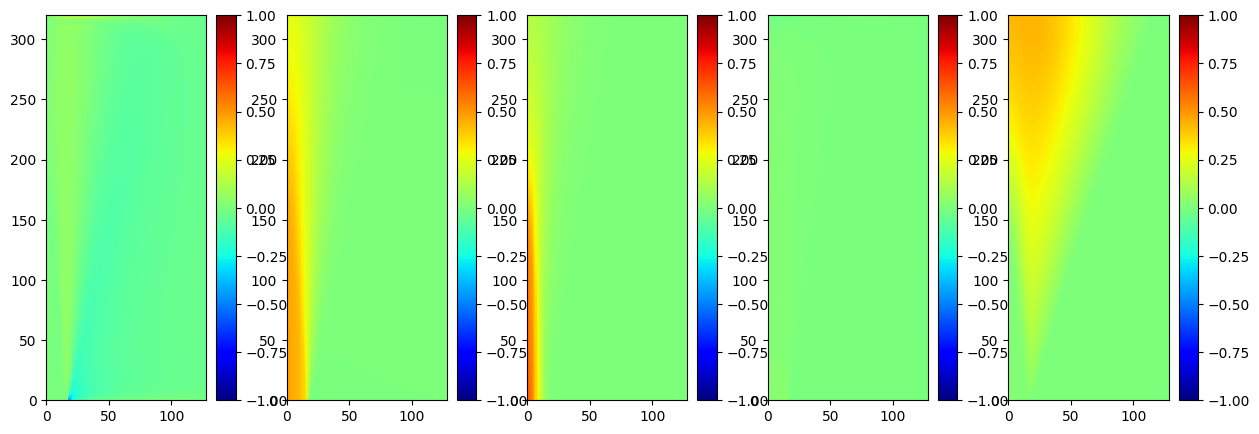

In [ ]:
simFields = next(iter(train_loader))
idx=0

fig, ax = plt.subplots(1,5, figsize=(15, 5))

for i in range(5):
    im = ax[i].pcolor(simFields[idx, i], cmap='jet', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        # 如果数据集最后一个batch样本数量小于定义的batch_batch大小，会出现mismatch问题。可以自己修改下，如只传入后面的shape，然后通过x.szie(0)，来输入。
        return x.view((x.size(0),)+self.shape)


class SEAttention(nn.Module):

    def __init__(self, channel=512,reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class autoencoder_n(nn.Module):
    def __init__(self,w,h,vector_l):
        super(autoencoder_n, self).__init__()

        self.vector_l=vector_l

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # (b, 16, 384, 192)
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 192, 96)
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 24, 12)
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 6, 3)
            Reshape(int(4*w*h/4096)),
            nn.Linear(int(4*w*h/4096),self.vector_l)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.vector_l,int(4*w*h/4096)),
            Reshape(4,int(w/64),int(h/64)),
            nn.Upsample(scale_factor=2, mode='nearest'),# (b, 4, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 4, 24, 12)
            nn.Conv2d(4, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 192, 96)
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            nn.Conv2d(16, 5, 3, stride=1, padding=1)
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

class autoencoder_attention_n(nn.Module):
    def __init__(self,w,h,n):
        super(autoencoder_attention_n, self).__init__()
        self.n=n

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # (b, 16, 384, 192)
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 192, 96)
            SEAttention(16, 2),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 24, 12)
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 12, 6)
            # SEAttention(16,2),
            # nn.AdaptiveAvgPool2d(1)
            Reshape(int(4 * w * h / 4096)),
            nn.Linear(int(4 * w * h / 4096), self.n)

        )

        self.decoder = nn.Sequential(
            nn.Linear(self.n, int(4 * w * h / 4096)),
            Reshape(4, int(w / 64), int(h / 64)),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 1, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),# (b, 1, 12, 6)
            nn.Conv2d(4, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 192, 96)
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            SEAttention(16, 2),
            nn.Conv2d(16, 5, 3, stride=1, padding=1)
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode


In [ ]:
class multi_head_autoencoder_n(nn.Module):
    def __init__(self,w,h,vector_l):
        super(multi_head_autoencoder_n, self).__init__()

        self.vector_l=vector_l

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # (b, 16, 384, 192)
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 192, 96)
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 8, 24, 12)
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),  # (b, 4, 6, 3)
            Reshape(int(4*w*h/4096)),
            nn.Linear(int(4*w*h/4096),self.vector_l)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.vector_l,int(4*w*h/4096)),
            Reshape(4,int(w/64),int(h/64)),
            nn.Upsample(scale_factor=2, mode='nearest'),# (b, 4, 12, 6)
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 4, 24, 12)
            nn.Conv2d(4, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 48, 24)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 96, 48)
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 8, 192, 96)
            #nn.Conv2d(8, 16, 3, stride=1, padding=1),
            #nn.Tanh(),
            #nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            #nn.Conv2d(16, 5, 3, stride=1, padding=1)
        )
        self.head0 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            nn.Conv2d(16, 1, 3, stride=1, padding=1)
        )
        self.head1 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            nn.Conv2d(16, 1, 3, stride=1, padding=1)
        )
        self.head2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            nn.Conv2d(16, 1, 3, stride=1, padding=1)
        )
        self.head3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (b, 16, 384, 192)
            nn.Conv2d(16, 1, 3, stride=1, padding=1)
        )

    def forward(self, x):
        encode = self.encoder(x)
        x = self.decoder(encode)
        vr = self.head0(x)
        vz = self.head1(x)
        p = self.head2(x)
        mut = self.head3(x)
        decode = torch.cat((vr, vz, p, mut), dim=1)
        return encode, decode

In [ ]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 32.7 MB/s eta 0:00:00


In [ ]:
import lightning as L

In [ ]:
num_epochs = 100

# Метрики

In [ ]:
class Metrics_ac():
    def __init__(self):

        self.NRMSE_mean = lambda x, y: \
                    torch.sqrt(torch.mean(torch.pow(x-y, 2)))/ \
                    torch.abs(torch.mean(y))
        self.NRMSE_every_point = lambda x, y: \
                    torch.sqrt(torch.mean(torch.pow(x/y-1, 2)))
        self.NRMSE_max = lambda x, y: \
                    torch.sqrt(torch.mean(torch.pow(x-y, 2)))/ \
                    torch.abs(torch.max(y))
        self.preds = []
        self.targets = []

    def calculate(self, pred, target):
        bs = pred.shape[0]
        mean_m, max_m, every_point_m = torch.zeros(bs), torch.zeros(bs), torch.zeros(bs)
        for j, (pred, target) in enumerate(zip(pred,  target)):
            for i, (p, t) in enumerate(zip(pred, target)):
                mean_m[i] = self.NRMSE_mean(p.float(), t.float())
                max_m[i] = self.NRMSE_max(p.float(), t.float())
                every_point_m[i] = self.NRMSE_every_point(p.float(), t.float())
        return torch.mean(mean_m), torch.mean(max_m), torch.mean(every_point_m)

In [ ]:
#0799bbe19111a7329a6383d0cea56de6490475b4

wandb.login()

wandb: Currently logged in as: ykrudenko (msu_263_rudenko). Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="DAE_PDE_v0",
        config={
            "lr": 1e-3,
            "comment": 'target + pde loss'
            })

In [ ]:
from torch.nn import MSELoss

class Lit_test1(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.metric = nn.L1Loss()
        self.metric_ders = torch.nn.MSELoss()
        self.train_acc = Metrics_ac()
        self.lamb=1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001,weight_decay=0)
        return optimizer

    def training_step(self, batch, batch_idx):

        train_inputs = batch[:, 2,:,:].unsqueeze(1)

        vector, train_outputs = self.model(train_inputs)
        #print(train_outputs.shape)

        loss_data_vr = self.metric(train_outputs[:,0], batch[:,0])
        loss_data_vz = self.metric(train_outputs[:,1], batch[:,1])
        #loss_data_T = self.metric(train_outputs[:,2], batch[:,2])
        loss_data_p = self.metric(train_outputs[:,2], batch[:,2])
        loss_data_muT = self.metric(train_outputs[:,3], batch[:,3])

        loss=loss_data_vr+loss_data_vz+loss_data_p+loss_data_muT
        #loss=loss_data

        metrics = {'loss_data_vr': loss_data_vr,
                   'loss_data_vz': loss_data_vz,
                   #'loss_data_T': loss_data_T,
                   'loss_data_p': loss_data_p,
                   'loss_data_muT': loss_data_muT,
                   'loss': loss
                   }

        acc_metrics = dict()

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,0].unsqueeze(1), batch[:,0].unsqueeze(1))
        acc_metrics['vr_mean'], acc_metrics['vr_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,1].unsqueeze(1), batch[:,1].unsqueeze(1))
        acc_metrics['vz_mean'], acc_metrics['vz_max'] = mean_m, max_m

        #mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,2].unsqueeze(1))
        #acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,3].unsqueeze(1))
        acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,3].unsqueeze(1), batch[:,4].unsqueeze(1))
        acc_metrics['muT_mean'], acc_metrics['muT_max'] = mean_m, max_m

        wandb.log(metrics)
        wandb.log(acc_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        pass


    def on_train_epoch_end(self):
        pass


    def on_validation_epoch_end(self):
        pass

    def forward(self, x):
      return self.model(x)


In [ ]:
ref = 'https://disk.yandex.ru/d/LKo54RqjQbs0Qw'
loadTextFromYandexDisk(ref, isZip=True)

In [ ]:
#path_w = '/content/3_DAE_PDE/model_w_v=64_320x128_500ep.pt'
path_w='/content/3_DAE_PDE/model_w_MH.pt'
vector_number = 64
N=320
M=128
model = multi_head_autoencoder_n(N, M, vector_number)

model.load_state_dict(torch.load(path_w))
model.eval()


multi_head_autoencoder_n(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [ ]:
v,out=model(torch.randn(1,1,320,128))
out.shape

torch.Size([1, 4, 320, 128])

In [ ]:
num_epochs = 1
L.seed_everything(42)
#torch.autograd.set_detect_anomaly(True)
lit_model = Lit_test1(model)

trainer_u = L.Trainer(max_epochs=num_epochs)

trainer_u.fit(model=lit_model, train_dataloaders=train_loader)

#wandb.finish()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type                     | Params
---------------------------------------------------------
0 | model       | multi_head_autoencoder_n | 15.0 K
1 | metric      | L1Loss                   | 0     
2 | metric_ders | MSELoss                  | 0     
-----------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


# Тест 1.
Знаю хорошее поле температуры из моделирования.
Знаю все остальные поля из моделирования.
Собираю автоэнкодер и пытаюсь его научить предсказывать все мои поля в точно таком же виде, как они есть.

Цель теста: собрать модель автоэнкодера и посмотреть, что DAE ничего не ипортить в модельных полях.

# Вывод:
лучше всего работает модель:


```
#
vector_number = 256
N=320
M=128
model = autoencoder_attention_n(N, M, vector_number)
```
тренировать эпох 300




In [ ]:
torch.save(model.state_dict(), 'model_w.pt')
filescolab.download('model_w.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
im = next(iter(train_loader))

In [ ]:
im.shape

torch.Size([32, 5, 320, 128])

In [ ]:
train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

In [ ]:
out.shape

torch.Size([32, 4, 320, 128])

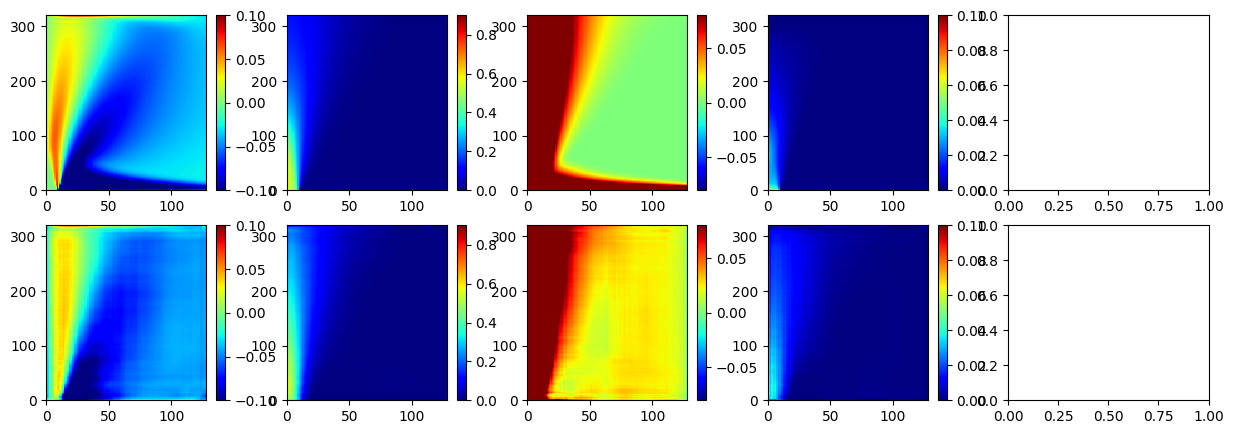

In [ ]:
idx=2

cax = [(-0.1, 0.1), (0, 0.9), (-0.08, 0.08), (0, 0.1)]
fig, ax = plt.subplots(2, 5, figsize=(15, 5))

for i in range(4):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet', vmin=cax[i][0], vmax=cax[i][1])
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet', vmin=cax[i][0], vmax=cax[i][1])
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

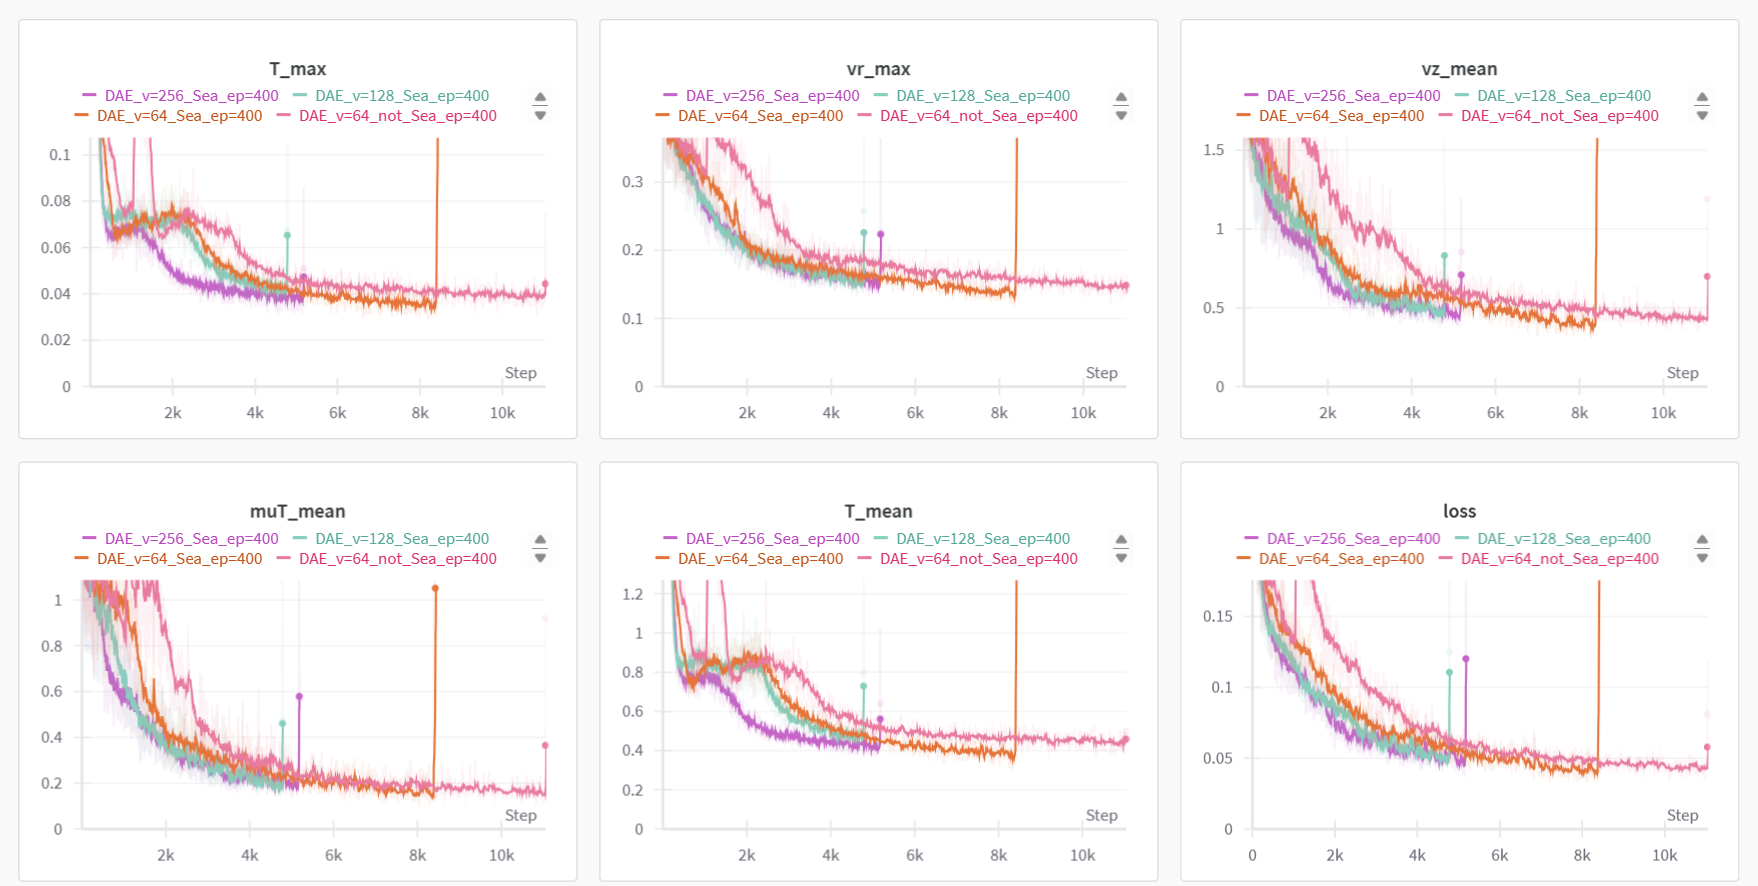

# Тест 2.
Подключаю уравнения в лосс-функцию.

In [ ]:
from torch.nn import MSELoss

class Lit_test2(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.metricL1 = nn.L1Loss()
        self.metricL2 = torch.nn.MSELoss()
        self.train_acc = Metrics_ac()
        self.lamb=1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001,weight_decay=0)
        return optimizer

    def training_step(self, batch, batch_idx):

        train_inputs = batch[:, 2,:,:].unsqueeze(1)

        vector, train_outputs = self.model(train_inputs)
        #print(train_outputs)

        #loss_data_vr = self.metricL1(train_outputs[:,0], batch[:,0])
        #loss_data_vz = self.metricL1(train_outputs[:,1], batch[:,1])
        loss_data_T = self.metricL1(train_outputs[:,2], batch[:,2])
        #loss_data_p = self.metricL1(train_outputs[:,3], batch[:,3])
        #loss_data_muT = self.metricL1(train_outputs[:,4], batch[:,4])

        f1 = pde_f1(train_outputs)
        f2 = pde_f2(train_outputs)
        f3 = pde_f3(train_outputs)
        f4 = pde_f4(train_outputs)

        f1_sim = pde_f1(batch)
        f2_sim = pde_f1(batch)
        f3_sim = pde_f1(batch)
        f4_sim = pde_f1(batch)

        loss_pde1 =  self.metricL2(f1, f1_sim)
        loss_pde2 =  self.metricL2(f2, f2_sim)
        loss_pde3 =  self.metricL2(f3, f3_sim)
        loss_pde4 =  self.metricL2(f4, f4_sim)

        #print(loss_pde1)

        #loss=loss_data_vr+loss_data_vz+loss_data_T+loss_data_p+loss_data_muT
        loss=loss_data_T+loss_pde1+loss_pde2+loss_pde3+loss_pde4

        metrics = {#'loss_data_vr': loss_data_vr,
                   #'loss_data_vz': loss_data_vz,
                   'loss_data_T': loss_data_T,
                   #'loss_data_p': loss_data_p,
                   #'loss_data_muT': loss_data_muT,
                   'loss_pde1': loss_pde1,
                   'loss_pde2': loss_pde2,
                   'loss_pde3': loss_pde3,
                   'loss_pde4': loss_pde4,

                   'loss': loss
                   }

        acc_metrics = dict()

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,0].unsqueeze(1), batch[:,0].unsqueeze(1))
        acc_metrics['vr_mean'], acc_metrics['vr_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,1].unsqueeze(1), batch[:,1].unsqueeze(1))
        acc_metrics['vz_mean'], acc_metrics['vz_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,2].unsqueeze(1))
        acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,3].unsqueeze(1), batch[:,3].unsqueeze(1))
        acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,4].unsqueeze(1), batch[:,4].unsqueeze(1))
        acc_metrics['muT_mean'], acc_metrics['muT_max'] = mean_m, max_m

        wandb.log(metrics)
        wandb.log(acc_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        pass


    def on_train_epoch_end(self):
        pass


    def on_validation_epoch_end(self):
        pass

    def forward(self, x):
      return self.model(x)


In [ ]:
wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="DAE_PDE_v0",
        config={
            "lr": 1e-3,
            "comment": 'target + pde loss'
            })

In [ ]:
#vector_number = 256
N=320
M=128
#model = autoencoder_attention_n(N, M, vector_number)

In [ ]:
num_epochs = 1
L.seed_everything(42)
#torch.autograd.set_detect_anomaly(True)
lit_model = Lit_test2(model)

trainer_u = L.Trainer(max_epochs=num_epochs)

trainer_u.fit(model=lit_model, train_dataloaders=train_loader)

#wandb.finish()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | multi_head_autoencoder_n | 16.3 K
1 | metricL1 | L1Loss                   | 0     
2 | metricL2 | MSELoss                  | 0     
--------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
im = next(iter(train_loader))

In [ ]:
train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

In [ ]:
metrs = Metrics_ac()

In [ ]:
im[idx,0].shape

torch.Size([320, 128])

In [ ]:
metrs.calculate(im[idx,1].unsqueeze(0).unsqueeze(0), out[idx,1].unsqueeze(0).unsqueeze(0))

(tensor(29.2406, grad_fn=<MeanBackward0>),
 tensor(7.0662, grad_fn=<MeanBackward0>),
 tensor(1312.4916, grad_fn=<MeanBackward0>))

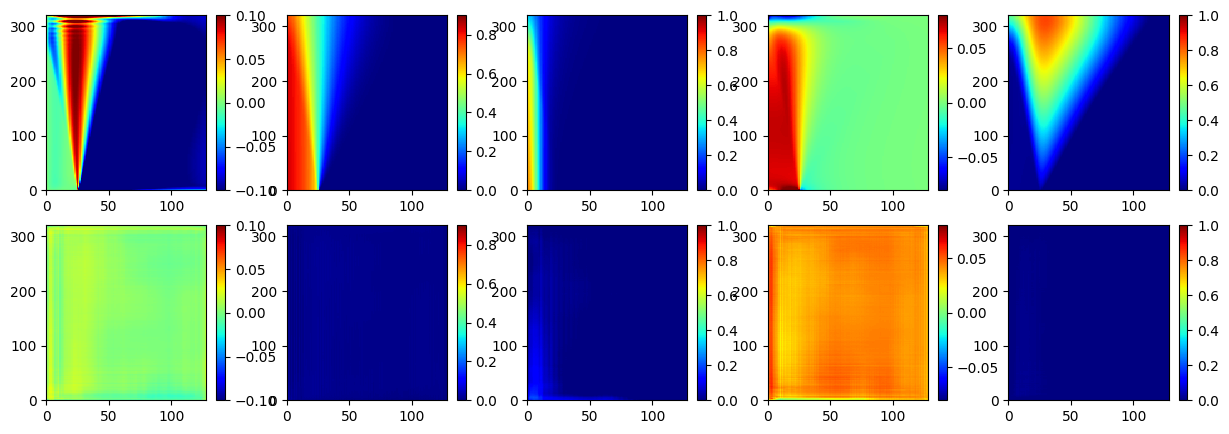

In [ ]:
idx=5

cax = [(-0.1, 0.1), (0, 0.9), (0, 1), (-0.08, 0.08), (0, 1)]
fig, ax = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet', vmin=cax[i][0], vmax=cax[i][1])
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet', vmin=cax[i][0], vmax=cax[i][1])
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

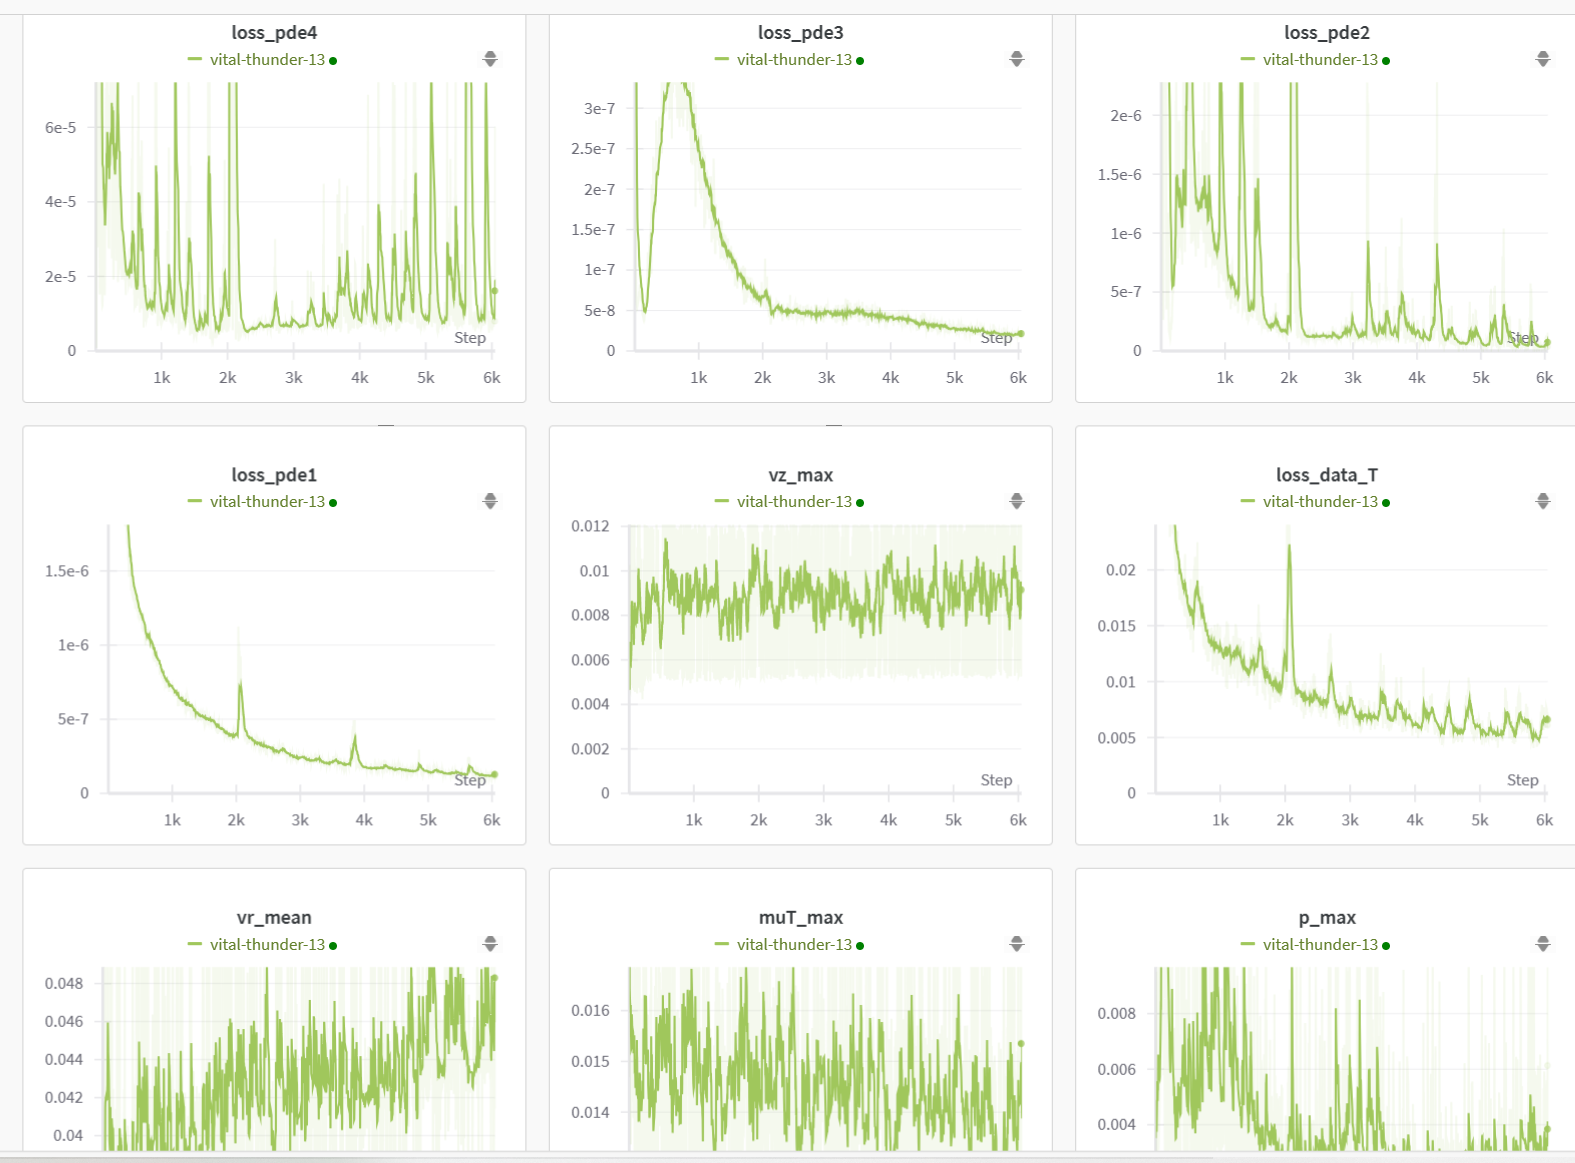

Решение не сходится к нужному - невязки падают, метрики растут

# Тест 3. Загрузить веса предобученной модели, подключить уравнение 1

In [ ]:
ref = 'https://disk.yandex.ru/d/LKo54RqjQbs0Qw'
loadTextFromYandexDisk(ref, isZip=True)

path_w = '/content/3_DAE_PDE/model_w_v=256_320x128_SEA.pt'

vector_number = 256
N=320
M=128
model = autoencoder_attention_n(N, M, vector_number)

In [ ]:
model.load_state_dict(torch.load(path_w))
model.eval()

autoencoder_attention_n(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SEAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=16, bias=False)
        (3): Sigmoid()
      )
    )
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
    (12): MaxPool2d(kernel_size=2, stride=2,

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


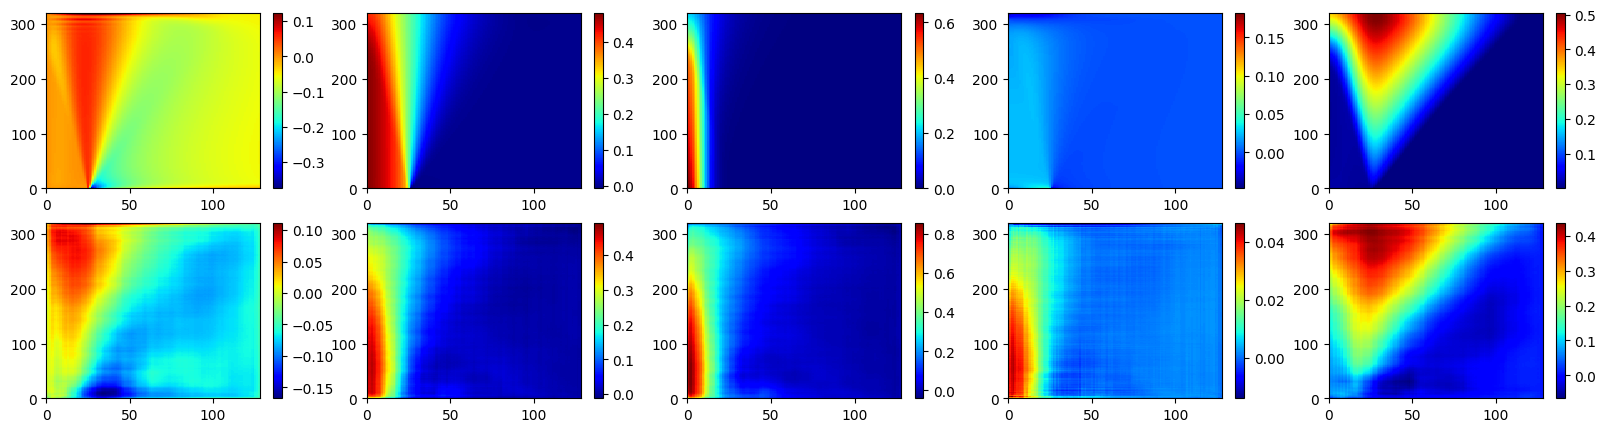

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

In [ ]:
from torch.nn import MSELoss

class Lit_test3(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.metricL1 = nn.L1Loss()
        self.metricL2 = torch.nn.MSELoss()
        self.train_acc = Metrics_ac()
        self.lamb=1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001,weight_decay=0)
        return optimizer

    def training_step(self, batch, batch_idx):

        train_inputs = batch[:, 2,:,:].unsqueeze(1)

        vector, train_outputs = self.model(train_inputs)
        #print(train_outputs)

        #loss_data_vr = self.metricL1(train_outputs[:,0], batch[:,0])
        #loss_data_vz = self.metricL1(train_outputs[:,1], batch[:,1])
        loss_data_T = self.metricL1(train_outputs[:,2], batch[:,2])
        #loss_data_p = self.metricL1(train_outputs[:,3], batch[:,3])
        #loss_data_muT = self.metricL1(train_outputs[:,4], batch[:,4])

        f1 = pde_f1(train_outputs)
        f2 = pde_f2(train_outputs)
        f3 = pde_f3(train_outputs)
        f4 = pde_f4(train_outputs)

        loss_pde1 =  self.metricL2(f1, torch.zeros_like(f1))
        loss_pde2 =  self.metricL2(f2, torch.zeros_like(f2))
        loss_pde3 =  self.metricL2(f3, torch.zeros_like(f3))
        loss_pde4 =  self.metricL2(f4, torch.zeros_like(f4))

        #print(loss_pde1)

        #loss=loss_data_vr+loss_data_vz+loss_data_T+loss_data_p+loss_data_muT
        loss=loss_data_T+loss_pde1

        metrics = {#'loss_data_vr': loss_data_vr,
                   #'loss_data_vz': loss_data_vz,
                   'loss_data_T': loss_data_T,
                   #'loss_data_p': loss_data_p,
                   #'loss_data_muT': loss_data_muT,
                   'loss_pde1': loss_pde1,
                   'loss_pde2': loss_pde2,
                   'loss_pde3': loss_pde3,
                   'loss_pde4': loss_pde4,

                   'loss': loss
                   }

        acc_metrics = dict()

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,0].unsqueeze(1), batch[:,0].unsqueeze(1))
        acc_metrics['vr_mean'], acc_metrics['vr_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,1].unsqueeze(1), batch[:,1].unsqueeze(1))
        acc_metrics['vz_mean'], acc_metrics['vz_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,2].unsqueeze(1))
        acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,3].unsqueeze(1), batch[:,3].unsqueeze(1))
        acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,4].unsqueeze(1), batch[:,4].unsqueeze(1))
        acc_metrics['muT_mean'], acc_metrics['muT_max'] = mean_m, max_m

        wandb.log(metrics)
        wandb.log(acc_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        pass


    def on_train_epoch_end(self):
        pass


    def on_validation_epoch_end(self):
        pass

    def forward(self, x):
      return self.model(x)


In [ ]:
wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="DAE_PDE_v0",
        config={
            "lr": 1e-3,
            "comment": 'test3'
            })

In [ ]:
num_epochs = 200
L.seed_everything(42)
#torch.autograd.set_detect_anomaly(True)
lit_model = Lit_test3(model)

trainer_u = L.Trainer(max_epochs=num_epochs)

trainer_u.fit(model=lit_model, train_dataloaders=train_loader)

#wandb.finish()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop

Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


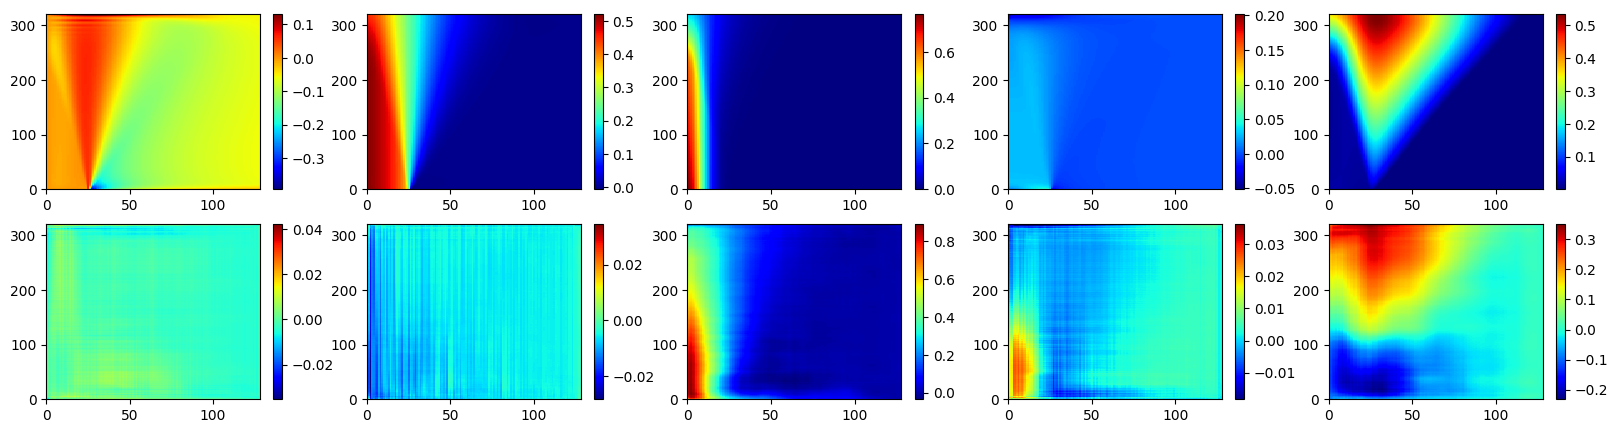

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

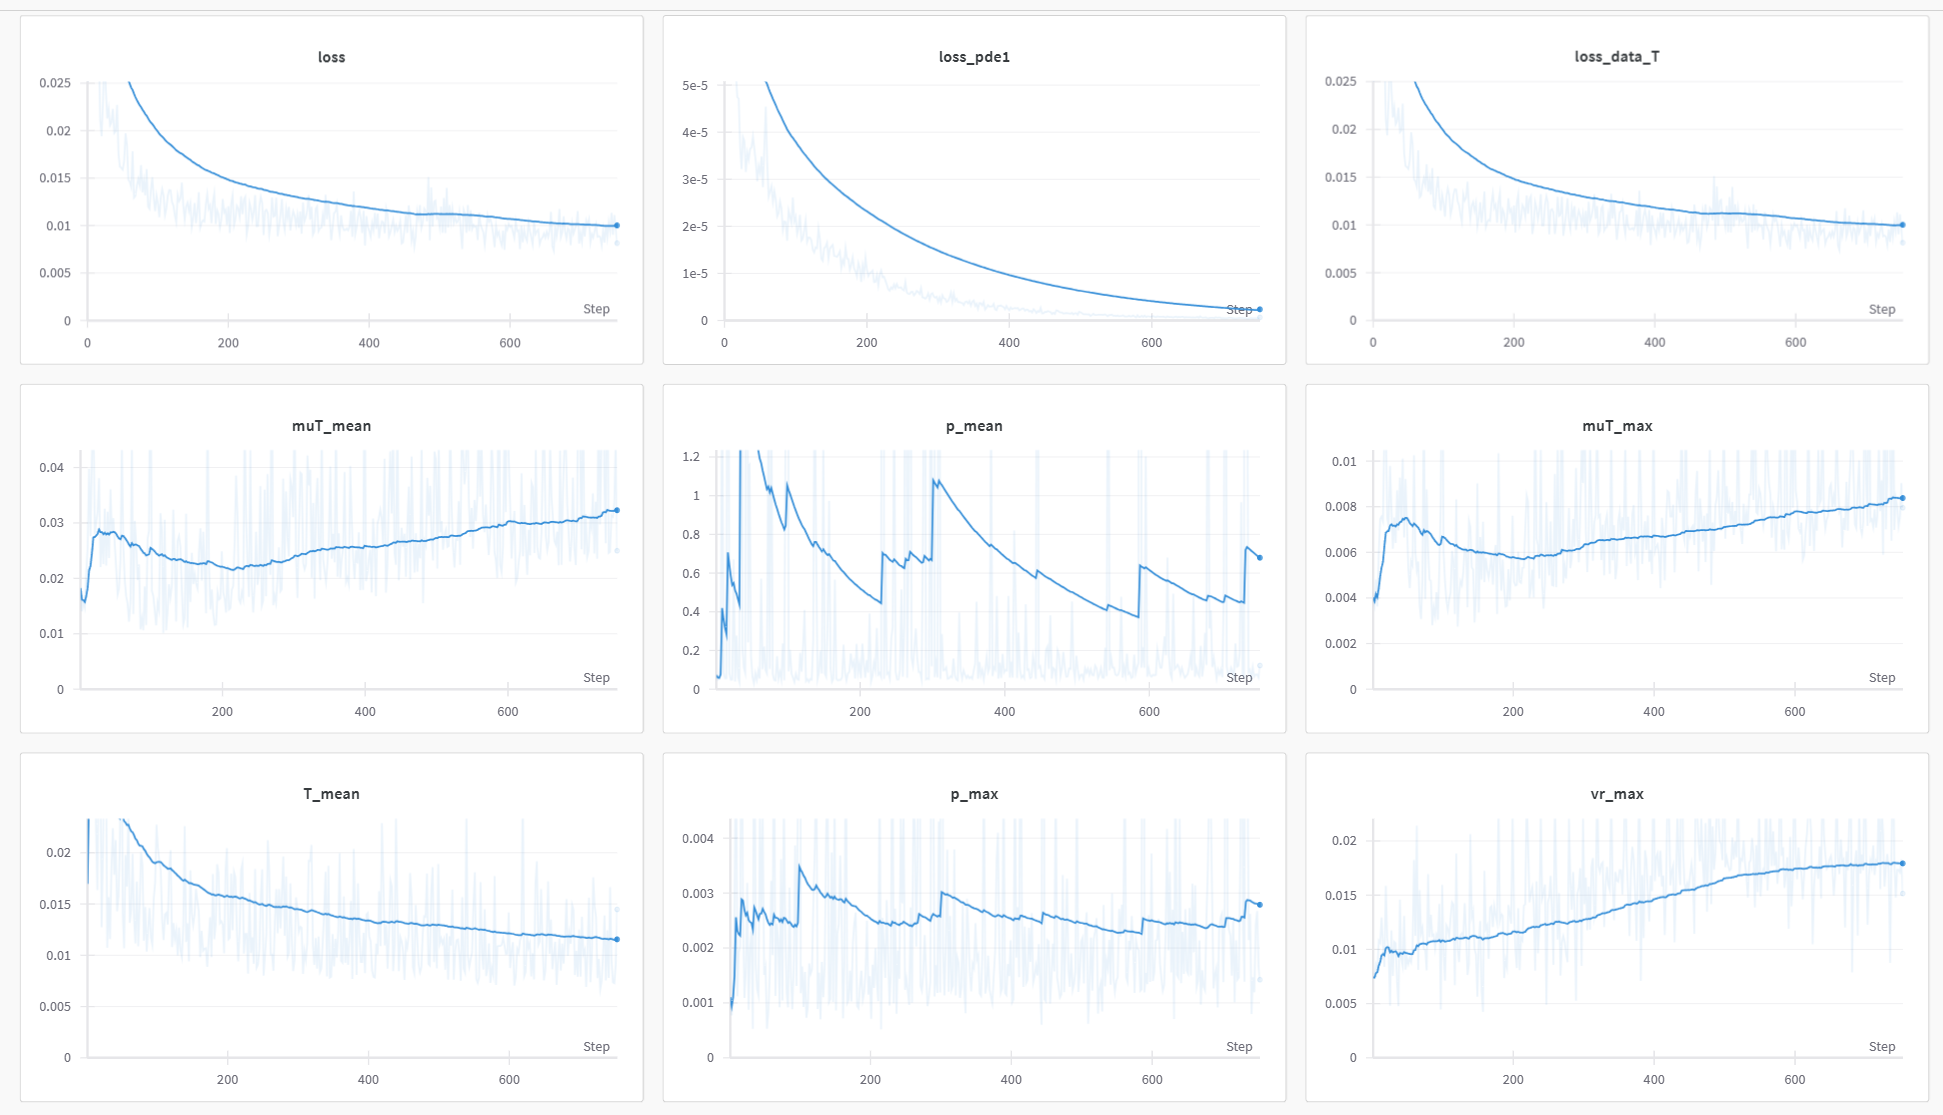

# Тест 4. Загрузить веса предобученной модели, подключить уравнение 4

In [ ]:
ref = 'https://disk.yandex.ru/d/LKo54RqjQbs0Qw'
loadTextFromYandexDisk(ref, isZip=True)

In [ ]:
path_w = '/content/3_DAE_PDE/model_w_v=256_320x128_SEA.pt'

vector_number = 256
N=320
M=128
model = autoencoder_attention_n(N, M, vector_number)

model.load_state_dict(torch.load(path_w))
model.eval()

autoencoder_attention_n(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SEAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=16, bias=False)
        (3): Sigmoid()
      )
    )
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
    (12): MaxPool2d(kernel_size=2, stride=2,

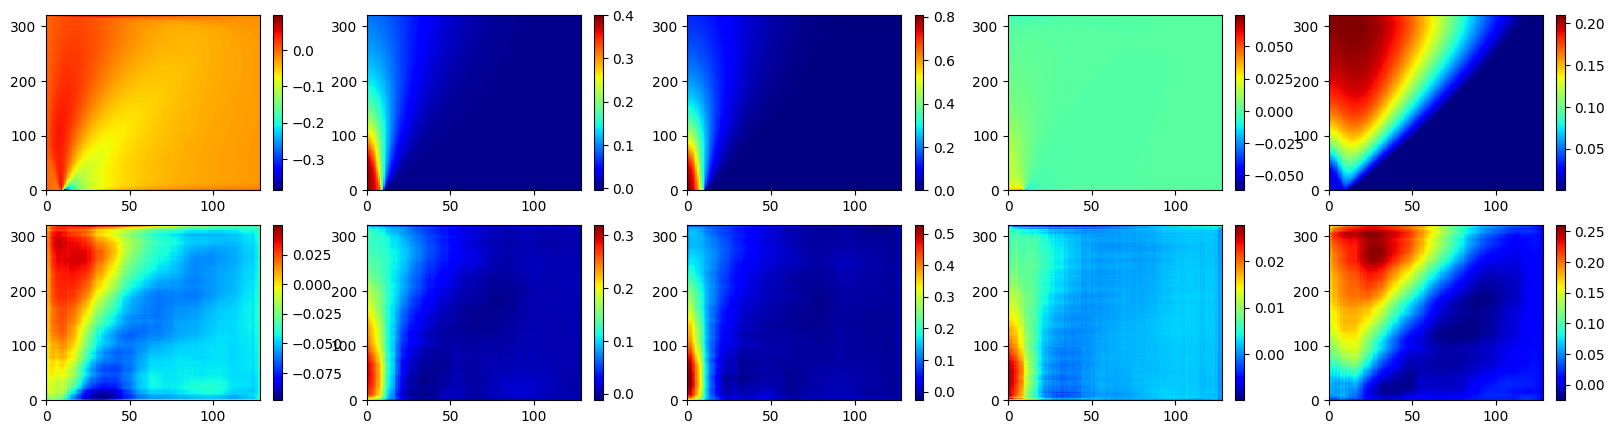

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

In [ ]:
from torch.nn import MSELoss

class Lit_test4(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.metricL1 = nn.L1Loss()
        self.metricL2 = torch.nn.MSELoss()
        self.train_acc = Metrics_ac()
        self.lamb=1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001,weight_decay=0)
        return optimizer

    def training_step(self, batch, batch_idx):

        train_inputs = batch[:, 2,:,:].unsqueeze(1)

        vector, train_outputs = self.model(train_inputs)
        #print(train_outputs)

        #loss_data_vr = self.metricL1(train_outputs[:,0], batch[:,0])
        #loss_data_vz = self.metricL1(train_outputs[:,1], batch[:,1])
        loss_data_T = self.metricL1(train_outputs[:,2], batch[:,2])
        #loss_data_p = self.metricL1(train_outputs[:,3], batch[:,3])
        #loss_data_muT = self.metricL1(train_outputs[:,4], batch[:,4])

        f1 = pde_f1(train_outputs)
        f2 = pde_f2(train_outputs)
        f3 = pde_f3(train_outputs)
        f4 = pde_f4(train_outputs)

        loss_pde1 =  self.metricL2(f1, torch.zeros_like(f1))
        loss_pde2 =  self.metricL2(f2, torch.zeros_like(f2))
        loss_pde3 =  self.metricL2(f3, torch.zeros_like(f3))
        loss_pde4 =  self.metricL2(f4, torch.zeros_like(f4))

        #print(loss_pde1)

        #loss=loss_data_vr+loss_data_vz+loss_data_T+loss_data_p+loss_data_muT
        loss=loss_data_T+loss_pde4

        metrics = {#'loss_data_vr': loss_data_vr,
                   #'loss_data_vz': loss_data_vz,
                   'loss_data_T': loss_data_T,
                   #'loss_data_p': loss_data_p,
                   #'loss_data_muT': loss_data_muT,
                   'loss_pde1': loss_pde1,
                   'loss_pde2': loss_pde2,
                   'loss_pde3': loss_pde3,
                   'loss_pde4': loss_pde4,

                   'loss': loss
                   }

        acc_metrics = dict()

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,0].unsqueeze(1), batch[:,0].unsqueeze(1))
        acc_metrics['vr_mean'], acc_metrics['vr_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,1].unsqueeze(1), batch[:,1].unsqueeze(1))
        acc_metrics['vz_mean'], acc_metrics['vz_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,2].unsqueeze(1))
        acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,3].unsqueeze(1), batch[:,3].unsqueeze(1))
        acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,4].unsqueeze(1), batch[:,4].unsqueeze(1))
        acc_metrics['muT_mean'], acc_metrics['muT_max'] = mean_m, max_m

        wandb.log(metrics)
        wandb.log(acc_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        pass


    def on_train_epoch_end(self):
        pass


    def on_validation_epoch_end(self):
        pass

    def forward(self, x):
      return self.model(x)


In [ ]:
wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="DAE_PDE_v0",
        config={
            "lr": 1e-3,
            "comment": 'test4'
            })

In [ ]:
num_epochs = 200
L.seed_everything(42)
#torch.autograd.set_detect_anomaly(True)
lit_model = Lit_test4(model)

trainer_u = L.Trainer(max_epochs=num_epochs)

trainer_u.fit(model=lit_model, train_dataloaders=train_loader)

#wandb.finish()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop

Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


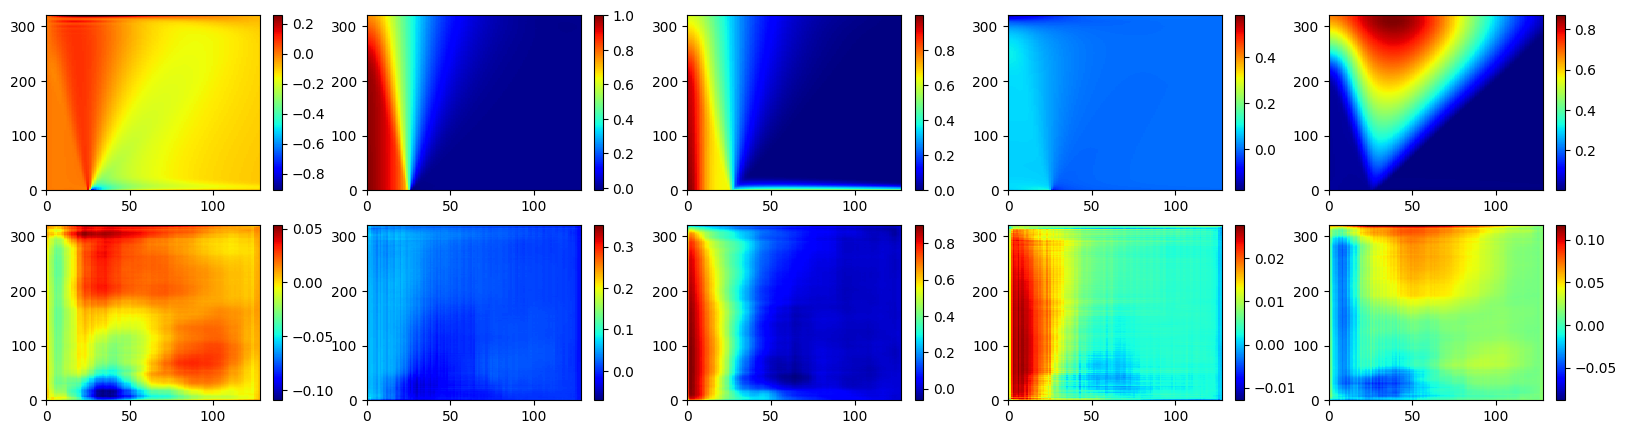

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

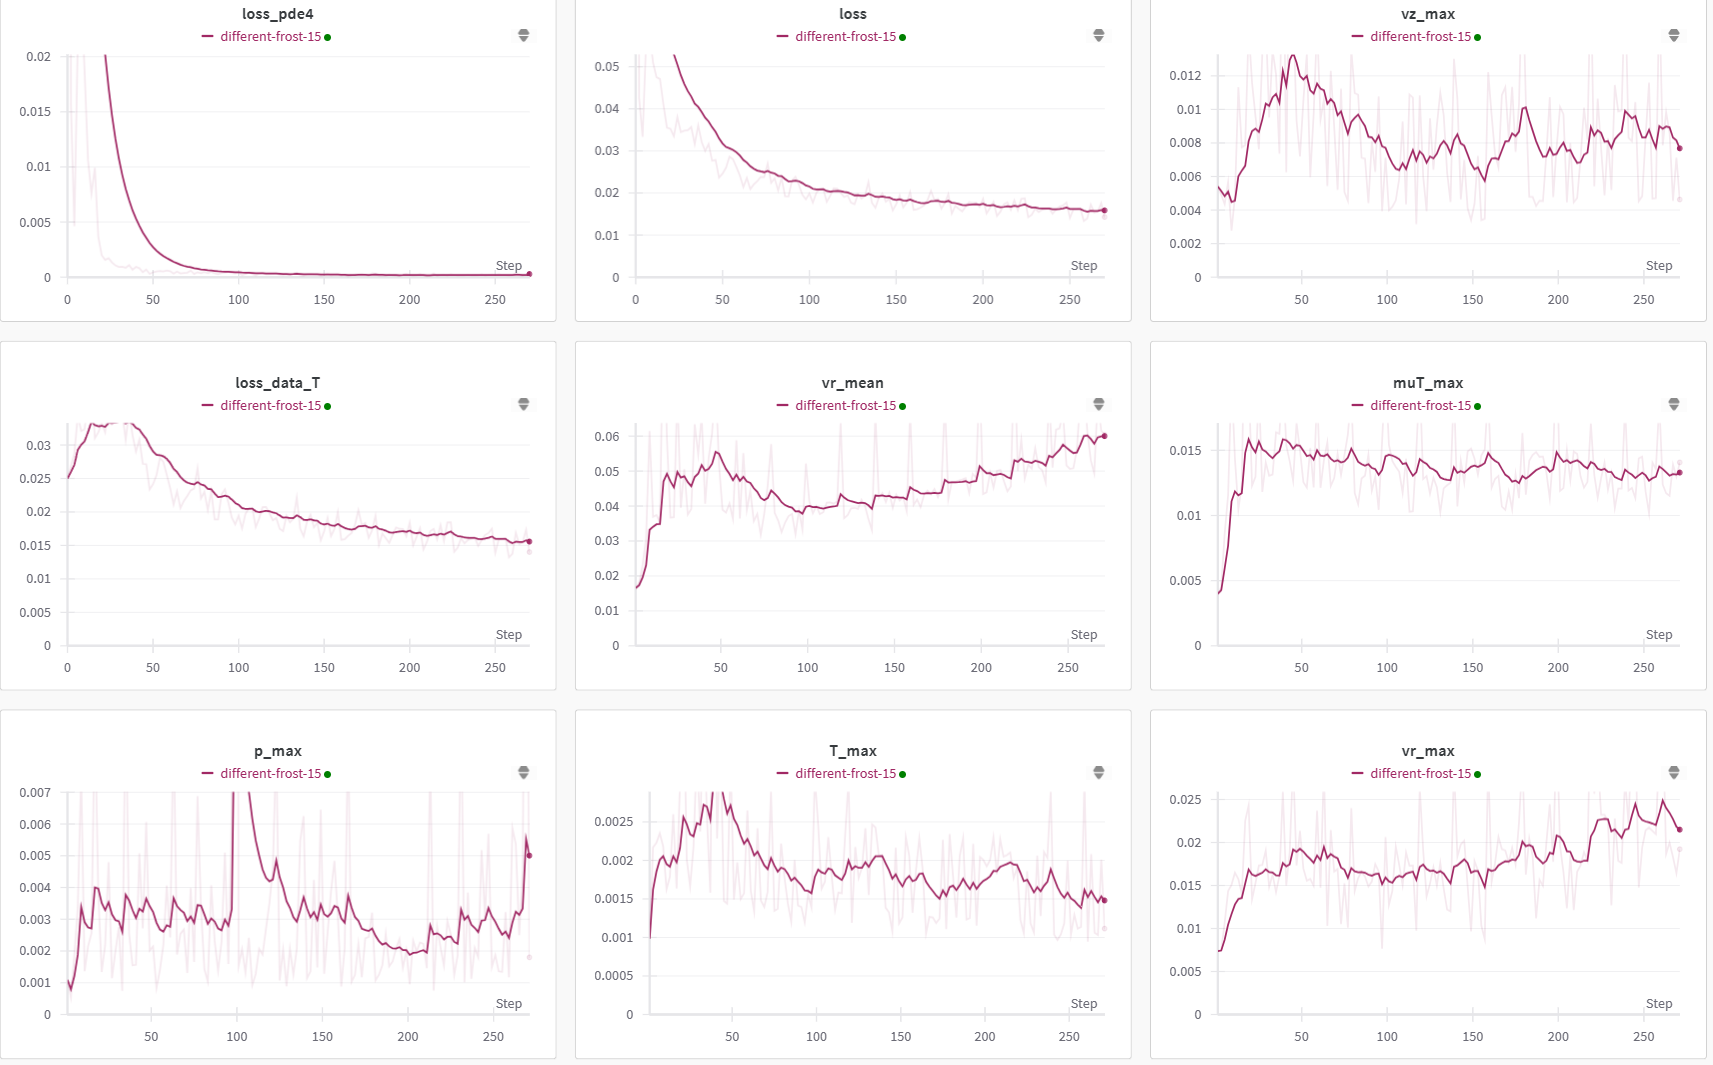

# Тест 5. Загрузить веса предобученной модели, подключить уравнение 2


In [ ]:
path_w = '/content/3_DAE_PDE/model_w_v=256_320x128_SEA.pt'

vector_number = 256
N=320
M=128
model = autoencoder_attention_n(N, M, vector_number)

model.load_state_dict(torch.load(path_w))
model.eval()

autoencoder_attention_n(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SEAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=16, bias=False)
        (3): Sigmoid()
      )
    )
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
    (12): MaxPool2d(kernel_size=2, stride=2,

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


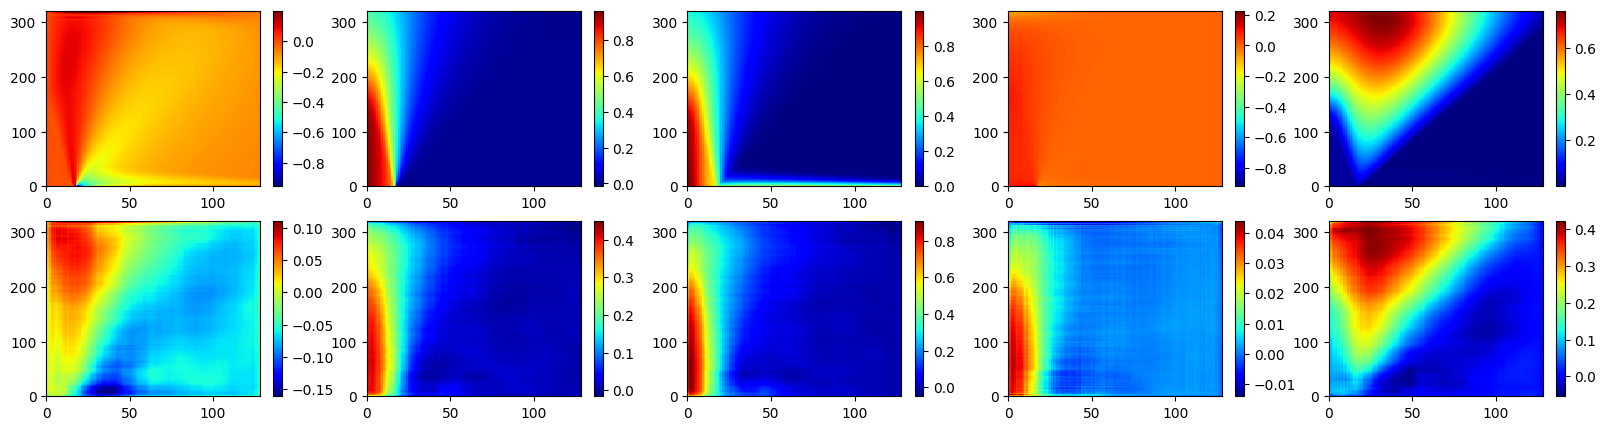

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

In [ ]:
from torch.nn import MSELoss

class Lit_test5(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.metricL1 = nn.L1Loss()
        self.metricL2 = torch.nn.MSELoss()
        self.train_acc = Metrics_ac()
        self.lamb=1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001,weight_decay=0)
        return optimizer

    def training_step(self, batch, batch_idx):

        train_inputs = batch[:, 2,:,:].unsqueeze(1)

        vector, train_outputs = self.model(train_inputs)
        #print(train_outputs)

        #loss_data_vr = self.metricL1(train_outputs[:,0], batch[:,0])
        #loss_data_vz = self.metricL1(train_outputs[:,1], batch[:,1])
        loss_data_T = self.metricL1(train_outputs[:,2], batch[:,2])
        #loss_data_p = self.metricL1(train_outputs[:,3], batch[:,3])
        #loss_data_muT = self.metricL1(train_outputs[:,4], batch[:,4])

        f1 = pde_f1(train_outputs)
        f2 = pde_f2(train_outputs)
        f3 = pde_f3(train_outputs)
        f4 = pde_f4(train_outputs)

        loss_pde1 =  self.metricL2(f1, torch.zeros_like(f1))
        loss_pde2 =  self.metricL2(f2, torch.zeros_like(f2))
        loss_pde3 =  self.metricL2(f3, torch.zeros_like(f3))
        loss_pde4 =  self.metricL2(f4, torch.zeros_like(f4))

        #print(loss_pde1)

        #loss=loss_data_vr+loss_data_vz+loss_data_T+loss_data_p+loss_data_muT
        loss=loss_data_T+loss_pde2

        metrics = {#'loss_data_vr': loss_data_vr,
                   #'loss_data_vz': loss_data_vz,
                   'loss_data_T': loss_data_T,
                   #'loss_data_p': loss_data_p,
                   #'loss_data_muT': loss_data_muT,
                   'loss_pde1': loss_pde1,
                   'loss_pde2': loss_pde2,
                   'loss_pde3': loss_pde3,
                   'loss_pde4': loss_pde4,

                   'loss': loss
                   }

        acc_metrics = dict()

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,0].unsqueeze(1), batch[:,0].unsqueeze(1))
        acc_metrics['vr_mean'], acc_metrics['vr_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,1].unsqueeze(1), batch[:,1].unsqueeze(1))
        acc_metrics['vz_mean'], acc_metrics['vz_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,2].unsqueeze(1), batch[:,2].unsqueeze(1))
        acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,3].unsqueeze(1), batch[:,3].unsqueeze(1))
        acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m

        mean_m, max_m, _ = self.train_acc.calculate(train_outputs[:,4].unsqueeze(1), batch[:,4].unsqueeze(1))
        acc_metrics['muT_mean'], acc_metrics['muT_max'] = mean_m, max_m

        wandb.log(metrics)
        wandb.log(acc_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        pass


    def on_train_epoch_end(self):
        pass


    def on_validation_epoch_end(self):
        pass

    def forward(self, x):
      return self.model(x)


In [ ]:
wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="DAE_PDE_v0",
        config={
            "lr": 1e-3,
            "comment": 'test5'
            })

In [ ]:
num_epochs = 1
L.seed_everything(42)
#torch.autograd.set_detect_anomaly(True)
lit_model = Lit_test5(model)

trainer_u = L.Trainer(max_epochs=num_epochs)

trainer_u.fit(model=lit_model, train_dataloaders=train_loader)

#wandb.finish()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                    | Params
-----------------------------------------------------
0 | model    | autoencoder_attention_n | 27.7 K
1 | metricL1 | L1Loss                  | 0     
2 | metricL2 | MSELoss                 | 0     
-------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


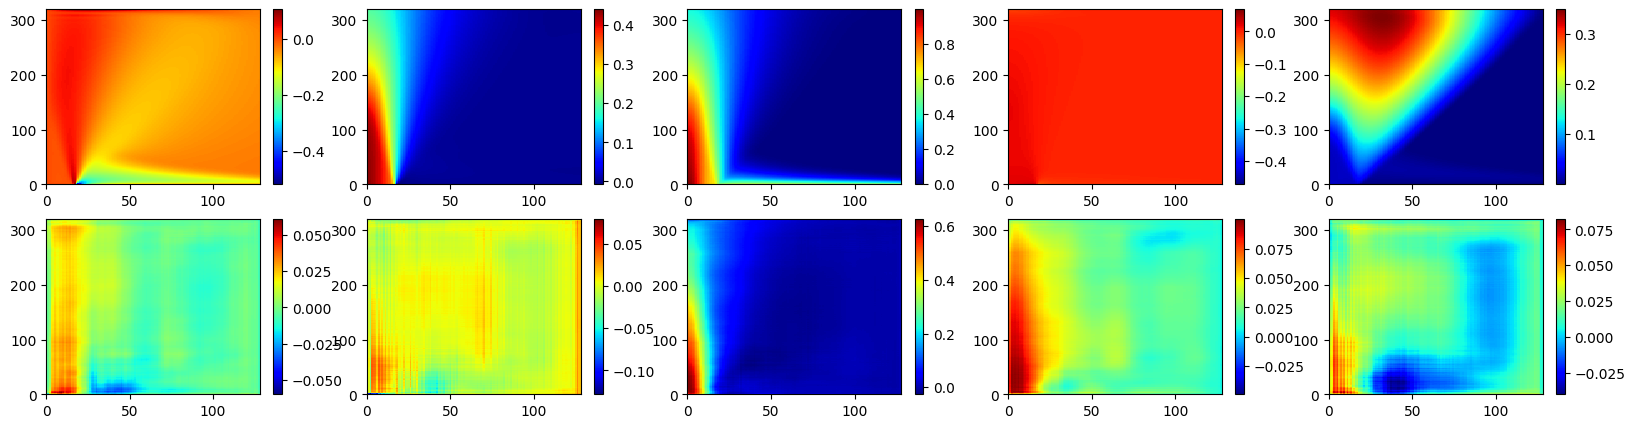

In [ ]:
im = next(iter(train_loader))

train_inputs = im[:, 1,:,:].unsqueeze(1)

vector, out = model(train_inputs)

idx=0

fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
  im_tar = ax[0, i].pcolor(im[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_tar, ax=ax[0, i])

  im_pred = ax[1, i].pcolor(out[idx,i].detach().cpu().numpy(), cmap='jet')
  plt.colorbar(im_pred, ax=ax[1, i])

plt.show()

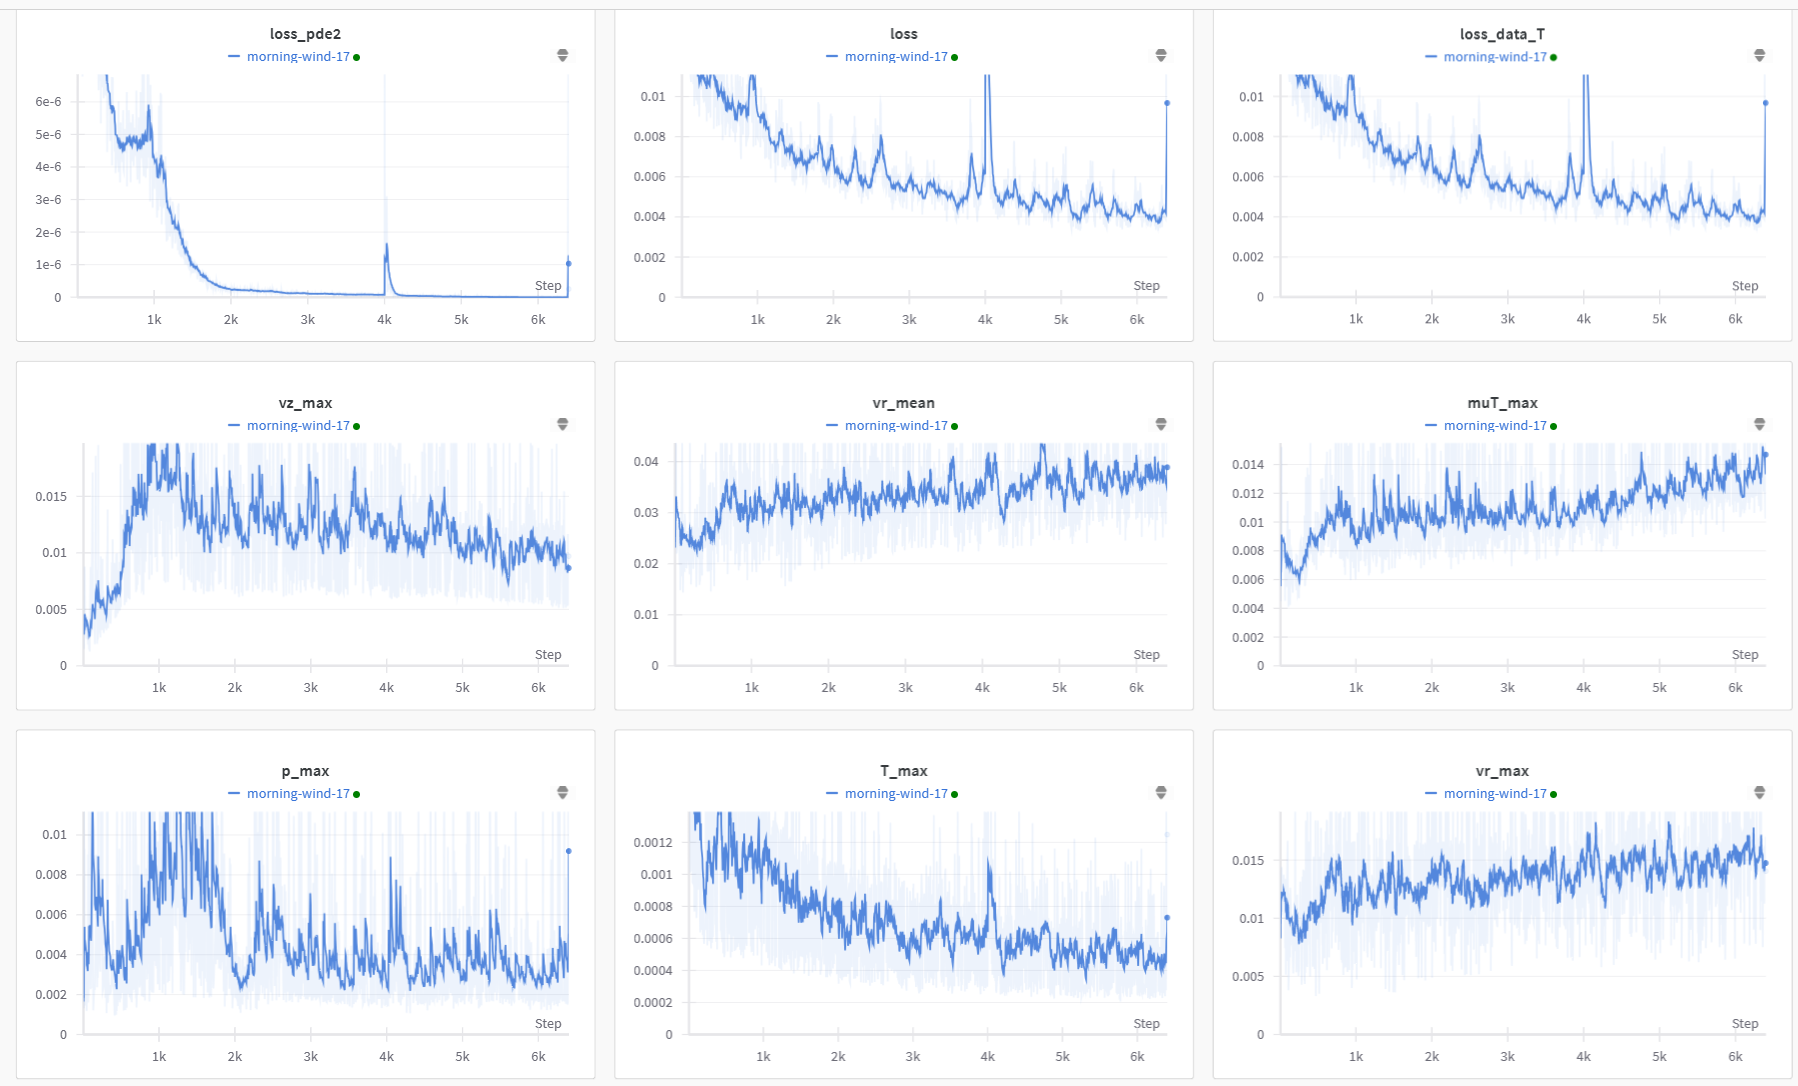